In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.visualization import quantity_support
quantity_support()

from libstarcam import (
    InterpolatableTable,
    Filter, Lens, Sensor, StarCamera,
    get_filter_transmission, get_optics_transmission,
    simple_snr_spectral
)

%matplotlib widget

In [2]:
lambd = np.arange(400, 1010, 10) * u.nm
F0 = 1.2e-12 * u.W / (u.cm**2) / u.um # I-band, McLean 2008, Table 9.4

# filter library
nofilter = Filter(F0) # technically wrong, not good approximation to I-band
red650 = Filter(
    F0, # not a bad match to I-band filter?
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=650*u.nm, width=7*u.nm, max_transmission=0.9)),
)
black760 = Filter(
    F0, # technically wrong, not good approximation to I-band
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=760*u.nm, width=7*u.nm, max_transmission=0.9)),
)
various = [Filter(
    F0, # technically wrong, not good approximation to I-band
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=l, width=7*u.nm, max_transmission=0.9)),
) for l in lambd]

# lens library
canon_200_28 = Lens(
    200 * u.mm,
    200 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2.8'
)
canon_200_2 = Lens(
    200 * u.mm,
    200 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2'
)

# sensor library
ui_3260 = Sensor(
    (1936, 1216),
    5.86 * u.um,
    0.35/u.s, # http://neutronoptics.com/soft/Manual-NeutronOptics-FLIR-CMOS-Camera.pdf
    21,
    8,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.58, 0.77, 0.61, 0.5, 0.39, 0.29, 0.2, 0.03, 0.0, 0.0])
    ),
    name='iDS uEye UI-3260-CP-M-GL'
)
u3_31n0se = Sensor(
    (5328,3040),
    2.74*u.um,
    1.38/u.s, # https://thinklucid.com/product/triton-16-2-mp-imx542/?srsltid=AfmBOorWeS_UYDtT8ZuoNhhgyEVhc7NRxoBQiFOYLiM8PHZ1PaTqk6eL
    1, # https://www.ximea.com/products/usb-vision-industrial/xic-sony-cmos-pregius-usb3-cameras/sony-imx542-usb3-color-industrial-camera
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.62, 0.72, 0.6, 0.53, 0.43, 0.34, 0.24, 0.04, 0.0, 0.0])
    ),
    name='iDS uEye U3-31N0SE-M-GL'
)
asi183mm = Sensor(
    (5496,3672),
    2.4*u.um,
    1.56/u.s, # @30 C, also the max measured value
    1.6,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        0.84 * np.array([0.7, 0.96, 0.93, 0.8, 0.73, 0.45, 0.25, 0.09, 0.0, 0.0])
    ),
    name='ZWO ASI183MM'
)

Text(0.5, 1.0, 'Response Function')

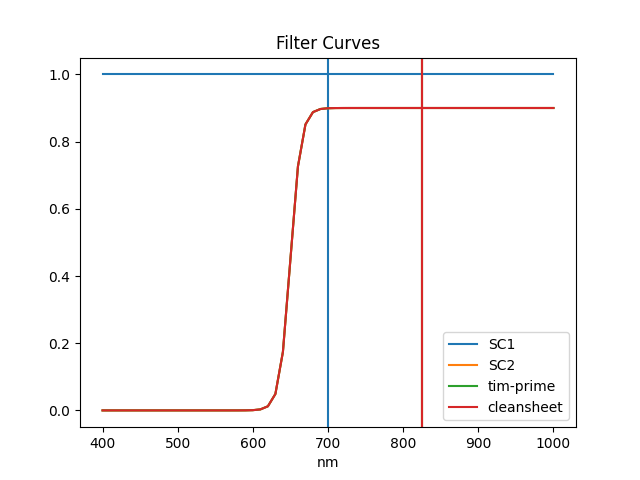

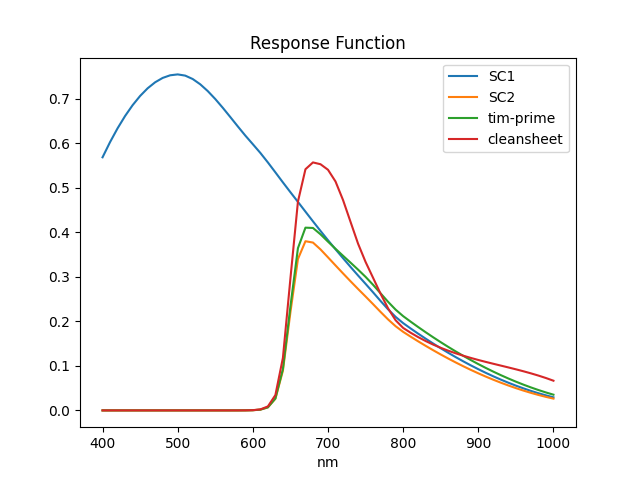

In [3]:
SC1 = StarCamera(ui_3260, canon_200_28, nofilter, name='SC1')
SC2 = StarCamera(ui_3260, canon_200_28, red650, name='SC2')
tim_prime = StarCamera(u3_31n0se, canon_200_2, red650, name='tim-prime')
cleansheet = StarCamera(asi183mm, canon_200_2, red650, name='cleansheet')

cams = [SC1, SC2, tim_prime, cleansheet]

fig, ax = plt.subplots()
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.filter.tau(lambd), color=color, label=cam.name)
    ax.axvline(cam.get_mean_lambd(lambd), color=color)
ax.legend()
ax.set_title('Filter Curves')

fig, ax = plt.subplots()
for cam in cams:
    ax.plot(lambd, cam.get_response(lambd), label=cam.name)
ax.legend()
ax.set_title('Response Function')

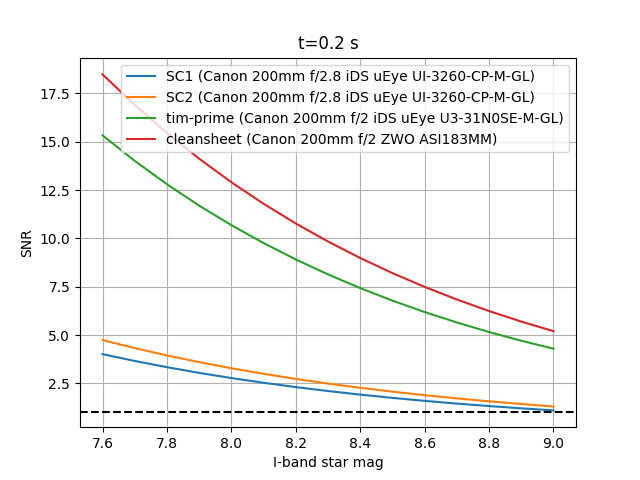

In [4]:
fig, ax = plt.subplots()

t_exp = 0.2 * u.s
mags = np.arange(9, 7.5, -0.1)
for cam in cams:
    snrs = []
    for mag in mags:
        snrs.append(simple_snr_spectral(t_exp, lambd, mag, cam))
    ax.plot(mags, snrs, label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})')
ax.axhline(1, linestyle='--', color='k')
ax.set_xlabel('I-band star mag')
ax.set_ylabel('SNR')
ax.set_title(f't={t_exp:0.1f}')
ax.grid()
ax.legend()

Text(0, 0.5, 'Stars Brighter than I$_{mag}$=9 in FoV)')

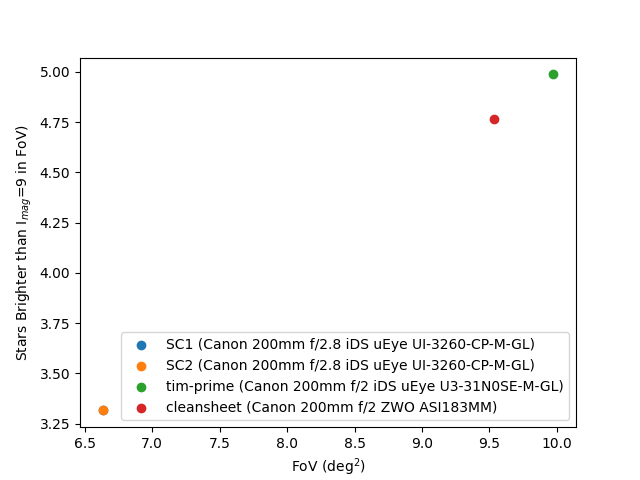

In [5]:
I_band_stars_per_deg2 = 0.5 / u.deg**2

fig, ax = plt.subplots()
for cam in cams:
    ax.scatter(cam.fov[0] * cam.fov[1], (cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2, label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})')
ax.legend()
ax.set_xlabel('FoV (deg$^2$)')
ax.set_ylabel('Avg. Stars Brighter than I$_{mag}$=9 in FoV)')

In [27]:
float_time = 8 * 3600 * u.s + (3 * 7 * 24 * 3600) * u.s
cadence = 3 * u.s
num_pics = float_time / cadence
print(f'For a total mission time of {float_time * (u.hr / (3600. * u.s))}, @ cadence {cadence}:')
for cam in cams:
    print(f'{cam.name}: {cam.sensor.megapixels:.1f} MP, {cam.sensor.frame_storage_size / 1e6 / 8:.2f} MB per pic, {num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000:.0f} GB total storage')

For a total mission time of 512.0 h, @ cadence 3.0 s:
SC1: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
SC2: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
tim-prime: 16.2 MP, 24.30 MB per pic, 14927 GB total storage
cleansheet: 20.2 MP, 30.27 MB per pic, 18599 GB total storage
